In [77]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import datetime
import unicodedata
from PIL import Image
from IPython.display import display

In [4]:
import os

file_path = "../data/MGN2021_MPIO_POLITICO/MGN_MPIO_POLITICO.shp"
print(os.path.exists(file_path))
data_folder = "../data/"
print(os.path.exists(data_folder))

True
True


In [5]:

colombia = gpd.read_file(file_path)


In [6]:
print(colombia.columns)

Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CDPMP', 'DPTO_CNMBR', 'MPIO_CNMBR',
       'MPIO_CRSLC', 'MPIO_NAREA', 'MPIO_CSMBL', 'MPIO_VGNC', 'MPIO_TIPO',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


In [7]:
print(colombia.head())

  DPTO_CCDGO MPIO_CCDGO MPIO_CDPMP DPTO_CNMBR  MPIO_CNMBR  \
0         05        001      05001  ANTIOQUIA    MEDELLÍN   
1         05        002      05002  ANTIOQUIA   ABEJORRAL   
2         05        004      05004  ANTIOQUIA    ABRIAQUÍ   
3         05        021      05021  ANTIOQUIA  ALEJANDRÍA   
4         05        030      05030  ANTIOQUIA       AMAGÁ   

                          MPIO_CRSLC  MPIO_NAREA MPIO_CSMBL  MPIO_VGNC  \
0                               1965  374.812877          4       2021   
1                               1814  507.141095          4       2021   
2                               1912  296.894050          4       2021   
3  Decreto departamental 304 de 1907  128.932153          4       2021   
4                               1912   84.132675          4       2021   

   MPIO_TIPO  Shape_Leng  Shape_Area  \
0  MUNICIPIO    1.032546    0.030606   
1  MUNICIPIO    1.158504    0.041384   
2  MUNICIPIO    0.812183    0.024248   
3  MUNICIPIO    0.705200    

In [8]:
colombia_bounds = colombia.total_bounds
colombia_polygon = box(*colombia_bounds)

In [10]:
# Definir tamaño de cuadrante en grados (1 km x 1 km aproximadamente)
grid_size = 0.01

# Calcular número de filas y columnas de cuadrantes
cols = int(np.ceil((colombia_bounds[2] - colombia_bounds[0]) / grid_size))
rows = int(np.ceil((colombia_bounds[3] - colombia_bounds[1]) / grid_size))

# Crear cuadrícula de cuadrantes
quadrants = []
for i in range(rows):
    for j in range(cols):
        quadrant = box(colombia_bounds[0] + j * grid_size, 
                       colombia_bounds[1] + i * grid_size,
                       colombia_bounds[0] + (j + 1) * grid_size,
                       colombia_bounds[1] + (i + 1) * grid_size)
        if colombia_polygon.intersects(quadrant):
            quadrants.append(quadrant.intersection(colombia_polygon))

# Unificar cuadrantes en un solo objeto MultiPolygon
quadrant_grid = unary_union(quadrants)


In [11]:
quadrant_ids = list(range(len(quadrants)))
quadrant_gdf = gpd.GeoDataFrame({'id': quadrant_ids, 'geometry': quadrants})

In [12]:
quadrant_gdf.to_file("cuadrantes_colombia.geojson", driver='GeoJSON')

In [18]:
quadrant_gdf.crs = "EPSG:4326"

In [19]:
quadrant_gdf_mercator = quadrant_gdf.to_crs(epsg=3857)

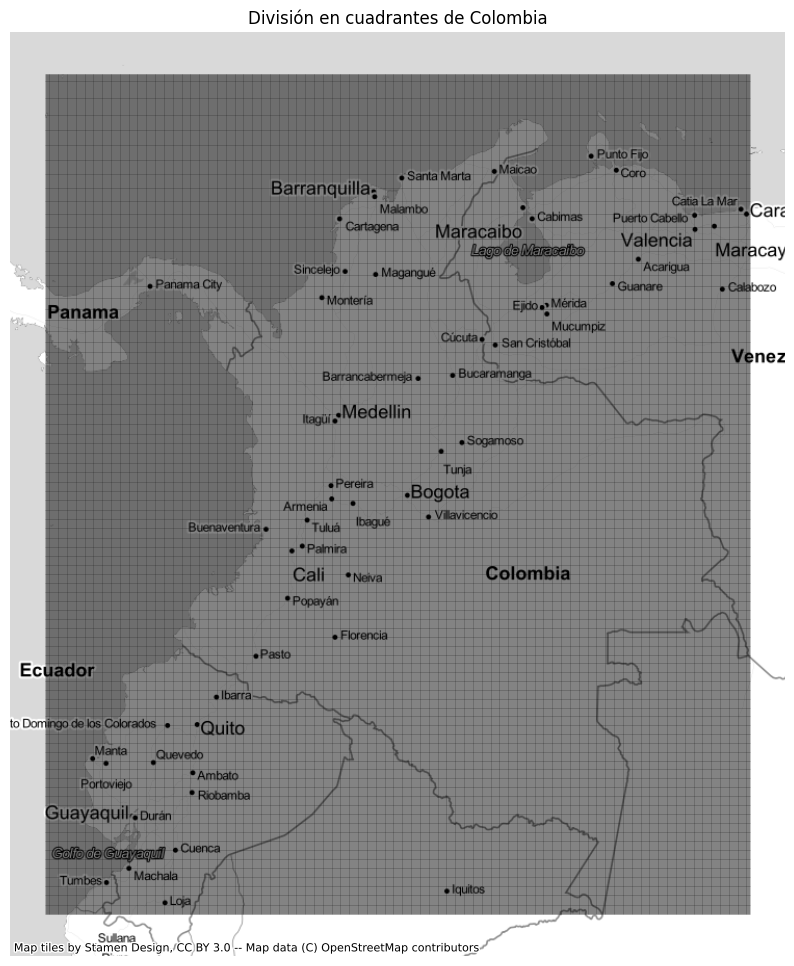

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
quadrant_gdf_mercator.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black', alpha=0.1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.title("División en cuadrantes de Colombia")
plt.show()

Croquis de Colombia por Municipios

In [13]:
gdf=gpd.read_file("../data/MGN2021_MPIO_POLITICO/MGN_MPIO_POLITICO.shp")

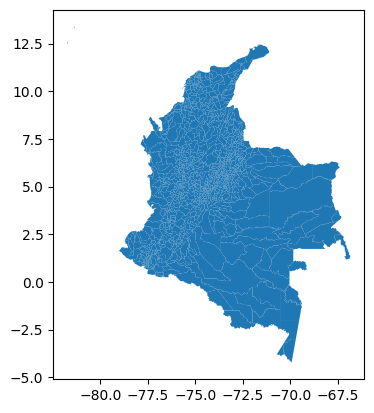

In [14]:
gdf.plot()
plt.show()

In [38]:
gdf['num_casos'] = 0

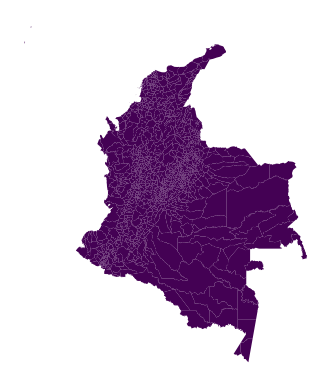

In [43]:
ax = gdf.plot(column='num_casos', cmap='viridis', linewidth=0, edgecolor='none')
ax.patch.set_visible(False)
ax.axis('off')
plt.show()

In [50]:
fig = ax.get_figure()

In [53]:
fig.savefig("../img/prueba.png", transparent=True, dpi = 1800)
fig.clf()

Para poder buscar efectivamente el municipio en gdf con respecto a los registros de feminicidios hay que modificar la columna

In [74]:
def remove_accents_and_uppercase(text):
    if not isinstance(text, str):
        return text
    
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    return text.upper()

In [76]:
columnas_a_transformar_colombia = ["DPTO_CNMBR", "MPIO_CNMBR"]
gdf[columnas_a_transformar_colombia]=gdf[columnas_a_transformar_colombia].applymap(remove_accents_and_uppercase)
gdf.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,value,num_casos
0,05,001,05001,ANTIOQUIA,MEDELLIN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360...",0,0
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571...",0,0
2,05,004,05004,ANTIOQUIA,ABRIAQUI,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((-76.08351 6.75050, -76.08325 6.75048...",0,0
3,05,021,05021,ANTIOQUIA,ALEJANDRIA,Decreto departamental 304 de 1907,128.932153,4,2021,MUNICIPIO,0.705200,0.010535,"POLYGON ((-75.03320 6.41586, -75.03313 6.41585...",0,0
4,05,030,05030,ANTIOQUIA,AMAGA,1912,84.132675,4,2021,MUNICIPIO,0.445241,0.006867,"POLYGON ((-75.67587 6.08561, -75.67540 6.08491...",0,0


Con la plantilla lista para ser usada, se procede a crear cada capa como una imagen distinta por cada dia desde que se registro el primer feminicidio en el dataframe del observatorio

In [65]:
feminicidios = pd.read_csv('../data/datos_observatorio_limpios.csv', encoding='utf-8', sep=',')

feminicidios['num_casos'] = feminicidios['num_casos'].astype(int)

feminicidios['fecha_en_prensa']=pd.to_datetime(feminicidios['fecha_en_prensa'], errors='coerce', dayfirst=True)

In [68]:
fecha_mas_antigua = feminicidios['fecha_en_prensa'].min()
ultima_fecha = feminicidios['fecha_en_prensa'].max()

print(fecha_mas_antigua,'-',ultima_fecha)

2018-01-02 00:00:00 - 2023-01-28 00:00:00


In [72]:
diferencia = ultima_fecha- fecha_mas_antigua
num_dias = diferencia.days
print(num_dias)
fecha_inicial=fecha_mas_antigua
fecha_final=ultima_fecha

1852


In [79]:
min_num_casos = feminicidios['num_casos'].min()
max_num_casos = feminicidios['num_casos'].max()

feminicidios['num_casos_normalizado'] = (feminicidios['num_casos'] - min_num_casos) / (max_num_casos - min_num_casos)


MemoryError: 

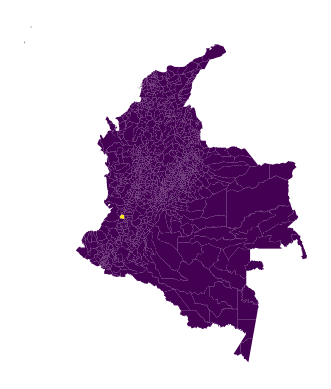

In [83]:
# Iterar por cada fecha en el rango de fechas
for fecha in pd.date_range(fecha_inicial, fecha_final, freq='D'):
    # Filtrar los registros de feminicidios para la fecha actual
    registros_fecha = feminicidios[feminicidios['fecha_en_prensa'] == fecha]

    if registros_fecha.empty:
        gdf['num_casos'] = 0
        ax = gdf.plot(column='num_casos', cmap='viridis', linewidth=0, edgecolor='none')

    if not registros_fecha.empty:
        gdf['num_casos'] = 0
        for index, row in registros_fecha.iterrows():
            municipio = row['municipio']
            num_casos = row['num_casos']
            gdf.loc[gdf['MPIO_CNMBR'] == municipio, 'num_casos'] = num_casos   
        ax = gdf.plot(column='num_casos', cmap='viridis', linewidth=0, edgecolor='none')

    ax.patch.set_visible(False)
    ax.axis('off')
    fig = ax.get_figure()
    nombre_archivo = f"../img/tensor-{fecha.strftime('%Y-%m-%d')}.png"
    fig.savefig(nombre_archivo, transparent=True, dpi=1800)
    fig.clf()
    plt.close(fig)

Ahora que las imagenes ya han sido creadas, voy a crear los tensores para utilizar una red neuronal convolucional LSTM (ConvLSTM)